In [1]:
import time
import itertools
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import mujoco

## Model
We will put a red_box in the origin and a green sphere in position 2 2 2

In [2]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
print(model.ngeom)
print(model.geom_rgba)
print(model.geom('green_sphere'))

2
[[1. 0. 0. 1.]
 [0. 1. 0. 1.]]
<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 1
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'green_sphere'
  pos: array([0.2, 0.2, 0.2])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.1])
  rgba: array([0., 1., 0., 1.], dtype=float32)
  sameframe: array([3], dtype=uint8)
  size: array([0.1, 0. , 0. ])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([2], dtype=int32)
  user: array([], dtype=float64)
>


`mjData` also contains *functions of the state*, for example the Cartesian positions of objects in the world frame. The (x, y, z) positions of our two geoms are in `data.geom_xpos`:

In [3]:
data = mujoco.MjData(model)
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]]


Wait, why are both of our geoms at the origin? Didn't we offset the green sphere? The answer is that derived quantities in `mjData` need to be explicitly propagated. In our case, the minimal required function is [`mj_kinematics`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-kinematics), which computes global Cartesian poses for all objects (excluding cameras and lights).

In [4]:
mujoco.mj_kinematics(model, data)
print('\nGREEN SPHERE:\n', data.geom('green_sphere').xpos)


GREEN SPHERE:
 [0.2 0.2 0.2]


## Simulation

""

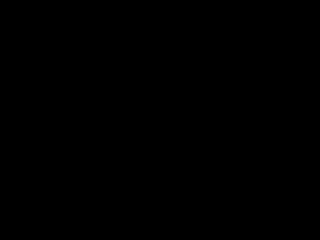

In [5]:
with mujoco.Renderer(model) as renderer:
  media.show_image(renderer.render())

Hmmm, why the black pixels?

**Answer:** For the same reason as above, we first need to propagate the values in `mjData`. This time we'll call [`mj_forward`](https://mujoco.readthedocs.io/en/latest/APIreference/APIfunctions.html#mj-forward), which invokes the entire pipeline up to the computation of accelerations i.e., it computes $\dot x = f(x)$, where $x$ is the state. This function does more than we actually need, but unless we care about saving computation time, it's good practice to call `mj_forward` since then we know we are not missing anything.

We also need to update the `mjvScene` which is an object held by the renderer describing the visual scene. We'll later see that the scene can include visual objects which are not part of the physical model.

""

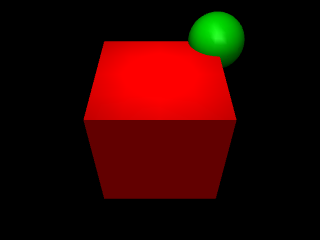

In [6]:
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

Now let's simulate and make a video. We'll use MuJoCo's main high level function `mj_step`, which steps the state $x_{t+h} = f(x_t)$. Note that in the code block below we are *not* rendering after each call to `mj_step`. This is because the default timestep is 2ms, and we want a 60fps video, not 500fps. We simulate with one [degree of freedom](https://www.google.com/url?sa=D&q=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FDegrees_of_freedom_(mechanics)) (DoFs). The things that move (and which have inertia) are called *bodies*. We add DoFs by adding *joints* to bodies, specifying how they can move with respect to their parents. Let's make a new body that contains our geoms, add a hinge joint and re-render, while visualizing the joint axis using the visualization option object `MjvOption`.

In [7]:
xml = """
<mujoco>
  <option gravity="0 0 -9.81"/>
  <option timestep="0.01"/>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 0">
      <joint name="swing" type="hinge" axis="0 1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.74  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data) # writes new state to data
    if len(frames) < data.time * framerate: # updates the scene every 1/framerate seconds
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)
      
media.show_video(frames, fps=framerate)

## Degrees Of Freedom
In the real world, all rigid objects have 6 degrees-of-freedom: 3 translations and 3 rotations. Real-world joints act as constraints, removing relative degrees-of-freedom from bodies connected by joints. Some physics simulation software use this representation which is known as the "Cartesian" or "subtractive" representation, but it is inefficient. MuJoCo uses a representation known as the "Lagrangian", "generalized" or "additive" representation, whereby objects have no degrees of freedom unless explicitly added using joints.

Our model, which has a single hinge joint, has one degree of freedom, and the entire state is defined by this joint's angle and angular velocity. These are the system's generalized position and velocity.

In [8]:
print('Total number of DoFs in the model:', model.nv)
print('Generalized positions:', data.qpos)
print('Generalized velocities:', data.qvel)

Total number of DoFs in the model: 1
Generalized positions: [0.13009277]
Generalized velocities: [-2.28922105]


A free body is a body with a [free joint](https://www.google.com/url?sa=D&q=https%3A%2F%2Fmujoco.readthedocs.io%2Fen%2Flatest%2FXMLreference.html%3Fhighlight%3Dfreejoint%23body-freejoint) having 6 DoFs, i.e., 3 translations and 3 rotations. We could give our `box_and_sphere` body a free joint and watch it fall, but let's look at something more interesting. A "tippe top" is a spinning toy which flips itself ([video](https://www.youtube.com/watch?v=kbYpVrdcszQ), [Wikipedia](https://en.wikipedia.org/wiki/Tippe_top)). We model it as follows:

In [9]:
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 0.5 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)

print('positions', data.qpos)
print('velocities', data.qvel)
print(data.geom_xpos)

duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
renderer = mujoco.Renderer(model)
with renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)  # writes new state to data
    if len(frames) < data.time * framerate:  # updates the scene every 1/framerate seconds
      renderer.update_scene(data, camera="closeup")
      pixels = renderer.render()
      frames.append(pixels)
      
media.show_video(frames, fps=framerate)

positions [0.   0.   0.02 1.   0.   0.   0.  ]
velocities [0. 0. 0. 0. 0. 0.]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


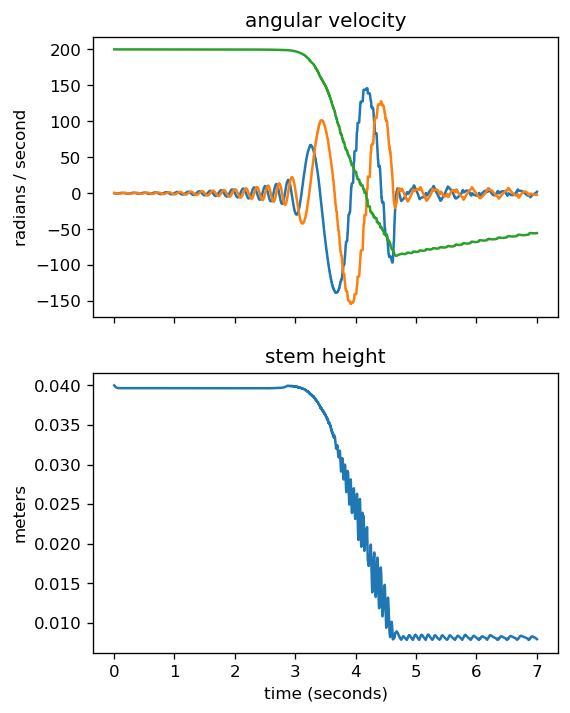

In [10]:
timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
mujoco.mj_resetDataKeyframe(model, data, 0)
while data.time < duration:
  mujoco.mj_step(model, data)
  timevals.append(data.time)
  angular_velocity.append(data.qvel[3:6].copy())
  stem_height.append(data.geom_xpos[2,2]);

dpi = 120
width = 600
height = 800
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')